In [ ]:
import torch,torchvision,os,PIL,pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(tensor, num=25,wandbactive=0,name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num],nrow=5).permute(1,2,0)
  #optional
  if (wandbactive ==1)  and (wandbact==1):
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})  
  plt.imshow(grid.clip(0,1))
  plt.show()



In [ ]:
#hyperparameters and general parameters
n_epochs =10000
batch_size = 128
lr=1e-4
z_dim=200
device='cuda'

cur_step=0
crit_cycles=5
gen_losses = []
crit_losses=[]
show_step=35
save_step=35

wandbact=1 

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login(key='4a6179d2f3c10eb556ff0fa1c6c64095c90e3768')

wandb: Currently logged in as: njn1234. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%capture
experiment_name = wandb.util.generate_id()
myrun = wandb.init(
    project='wgan',
    group= experiment_name,
    config={
        "optimizer":"sgd",
        "model":"wgan_gp",
        "epoch":"1000",
        "batch_size":128
    }
)
config=wandb.config

In [ ]:
print(experiment_name)

4jgo1rty


In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim=64,d_dim=16):
    super(Generator,self).__init__()
    self.z_dim=z_dim
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(z_dim,d_dim*32,4,1,0), ##  4 x 4 (ch: 200,512)
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32,d_dim*16,4,2,1), ## 8x 8 (ch: 512,256)
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),  

        nn.ConvTranspose2d(d_dim*16,d_dim*8,4,2,1), ## 16x16 (ch: 256,128)
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True), 

        nn.ConvTranspose2d(d_dim*8,d_dim*4,4,2,1), ## 32x32 (ch: 128,64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True), 

        nn.ConvTranspose2d(d_dim*4,d_dim*2,4,2,1), ## 64x64 (ch: 64,32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True),  

        nn.ConvTranspose2d(d_dim*2,3,4,2,1), ## 64x64 (ch: 32,3)
        nn.Tanh()          
    )

  def forward(self,noise):
    x=noise.view(len(noise),self.z_dim,1,1) # 128x200x1x1
    return self.gen(x)

def gen_noise(num,z_dim,device='cuda'):
  return torch.randn(num,z_dim,device=device)




In [ ]:
# nn.ConvTranspose2d : (n-1)*stride - 2*padding + ks
# nn.Conv2d: (n+2*pad-ks)//stride +1
# in_channels,out_channels,kernel_size,padding

In [ ]:
class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super(Critic,self).__init__()

    self.crit = nn.Sequential(
        nn.Conv2d(3,d_dim,4,2,1), #(n+2*pad-ks)//stride+1 = 64x64 (ch:3,16)
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim,d_dim*2,4,2,1), #(n+2*pad-ks)//stride+1 = 
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2), 

        nn.Conv2d(d_dim*2,d_dim*4,4,2,1), #(n+2*pad-ks)//stride+1 = 
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2), 

        nn.Conv2d(d_dim*4,d_dim*8,4,2,1), #(n+2*pad-ks)//stride+1 = 
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8,d_dim*16,4,2,1), #(n+2*pad-ks)//stride+1 = 
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2), 

        nn.Conv2d(d_dim*16,1,4,1,0), #(n+2*pad-ks)//stride+1 = 
       
    )

  def forward(self,image):
    crit_pred  = self.crit(image) # 128
    return crit_pred.view(len(crit_pred),-1)



In [ ]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(nn.Conv2dTranspose):
    torch.nn.init.normal(m.weight,0.0,0.02)
    torch.nn.init.constant(m.bias,0)

  if isinstance(m,nn.BatchNorm2f):
    torch.nn.init.normal(m.weight,0.0,0.02)
    torch.nn.init.constant(m.bias,0)

# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)


In [ ]:
#load dataset
import gdown,zipfile
path = "data/celeba"


In [ ]:
download_path = "/content/drive/MyDrive/img_align_celeba.zip"

In [ ]:
if not os.path.exists(path):
  os.makedirs(path)

In [ ]:
with zipfile.ZipFile(download_path,'r') as ziphandler:
  ziphandler.extractall(path)

In [ ]:
path

'data/celeba'

In [ ]:
class Dataset(Dataset):
  def __init__(self,path,size=128,lim=10000):
    self.sizes=[size,size]
    items,labels=[],[]

    for data in os.listdir(path+'/img_align_celeba/')[:lim]:
      item = os.path.join(path+'/img_align_celeba',data)
      items.append(item)
      labels.append(data)
    self.items=items
    self.labels=labels

  def __len__(self):
      return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB')#(178x218)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) #128x128x3
    data  = np.transpose(data,(2,0,1)).astype(np.float32,copy=False)# 3x 128 x 128
    data = torch.from_numpy(data).div(255)
    return data,self.labels[idx]
  
## Dataset
data_path = 'data/celeba'
ds = Dataset(data_path,size=128,lim=10000)

In [ ]:
dataloader = DataLoader(ds,batch_size=batch_size,shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)

In [ ]:
crit  = Critic().to(device)

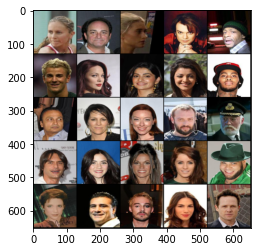

In [ ]:
#optimizer
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas = (0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(),lr=lr,betas = (0.5,0.9))
if wandbact==1:
  wandb.watch(gen,log_freq=100)
  wandb.watch(crit,log_freq=100)

x,y = next(iter(dataloader))
show(x)


In [ ]:
## gradient penalty

def get_gp(real,fake,crit,alpha,gamma=10):
  mix_images = real * alpha + fake * (1- alpha) # 128 * 3 * 128 * 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient =  torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True
  )[0]

  gradient = gradient.view(len(gradient),-1)
  gradient_norm = gradient.norm(2,dim=1)
  gp = ((gradient_norm-1)**2).mean()
  return gp



In [ ]:
##Save and load checkpoints
root_path = './data/'

def save_checkpoint(name):
  torch.save({
       'epoch':epoch,
       'model_state_dict':gen.state_dict(),
       'optimizer_state_dict':gen_opt.state_dict()
   },f"{root_path}G-{name}.pkl")

  torch.save({
       'epoch':epoch,
       'model_state_dict':crit.state_dict(),
       'optimizer_state_dict':crit_opt.state_dict()
   },f"{root_path}C-{name}.pkl")
  print("Saved Checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")



In [ ]:
epoch=1
save_checkpoint("test")
load_checkpoint("test")



Saved Checkpoint
Loaded checkpoint


In [ ]:
for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
    cur_bs = len(real)
    real = real.to(device)

    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs,z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real),1,1,1,device=device,requires_grad=True)#128x1x1x1
      gp = get_gp(real,fake.detach(),crit,alpha)
      
      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss.item() / crit_cycles
      crit_loss.backward(retain_graph=True)
      crit_opt.step()
    crit_losses+=[mean_crit_loss]

    ##GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs,z_dim)
    fake =  gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()
    gen_losses+=[gen_loss.item()]

    ##Stats

    if wandbact==1:
      wandb.log({'Epoch':epoch,'Step':cur_step,'Critic loss':mean_crit_loss,'Gen loss':gen_loss})

    if cur_step % save_step ==0  and cur_step>0:
      print("Saving checkpoint: ", cur_step, save_step)
      save_checkpoint("latest")
    if (cur_step % show_step == 0) and (cur_step > 0) :
      show(fake,wandbactive=1,name='fake')
      show(real,wandbactive=1,name='real')
      gen_mean = sum(gen_losses[-show_step:])/show_step
      crit_mean = sum(crit_losses[-show_step:])/show_step
      print(f"Epoch: {epoch}: Step {cur_step} : Generator_loss:{gen_mean} : critic_loss:{crit_mean}")
      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator loss"
      )

      plt.plot(
          range(len(crit_losses)),
          torch.Tensor(crit_losses),
          label="Critic loss"
      )

      plt.ylim(-1000,1000)
      plt.legend()
      plt.show()
    
    cur_step+=1


  
      

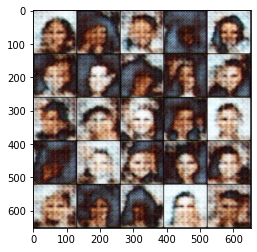

In [ ]:
show(fake,wandbactive=1,name='fake')